# Investigate prior of moments for frequent actions / objects

In [1]:
cd ../../

/mnt/sda/otani/Experiments/moment_retrieval


In [78]:
%matplotlib inline
import matplotlib as mpl
from typing import List
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
from src.toolbox.utils import _nms, sentence2token, _load_top_actions
from src.toolbox.eval import evaluate, location_error, accumulate_metrics, categorize_results, summarize_results_per_class
from src.toolbox.visualization import plot_performance_per_class, plot_performance_per_duration
from src.toolbox.data_converters import Charade2Instances
from src.toolbox.baseline import SegmentGeneratorKDE, predict
import seaborn as sns
sns.set_style("white")

In [4]:
train_data = Charade2Instances(pd.read_csv('data/processed/train.csv'))

blind_segment_generator = SegmentGeneratorKDE()
blind_segment_generator.fit("base", train_data)

#instances: 12408


In [10]:
sentences = [query[1] for query, _ in train_data]
tokens = [sentence2token(x) for x in sentences]

In [20]:
# sentences = [query[1] for query, _ in train_data]
# tokens = [sentence2token for x in sentences]
top_actions = _load_top_actions("charade")
segment_generator = SegmentGeneratorKDE()
for action in top_actions:
    indices = [i for i, query in enumerate(tokens) if action in query[0]]
    sub_train = [train_data[i] for i in indices]
    segment_generator.fit(action, sub_train)
segment_generator.fit("base", train_data)

#instances: 1421
#instances: 1154
#instances: 949
#instances: 870
#instances: 810
#instances: 780
#instances: 591
#instances: 545
#instances: 523
#instances: 504
#instances: 439
#instances: 419
#instances: 395
#instances: 378
#instances: 306
#instances: 297
#instances: 266
#instances: 258
#instances: 256
#instances: 239
#instances: 204
#instances: 202
#instances: 176
#instances: 173
#instances: 161
#instances: 139
#instances: 105
#instances: 103
#instances: 102
#instances: 78
#instances: 72
#instances: 63
#instances: 60
#instances: 52
#instances: 51
#instances: 48
#instances: 34
#instances: 33
#instances: 29
#instances: 26
#instances: 23
#instances: 23
#instances: 22
#instances: 17
#instances: 16
#instances: 13
#instances: 13
#instances: 13
#instances: 12
#instances: 12
#instances: 12408


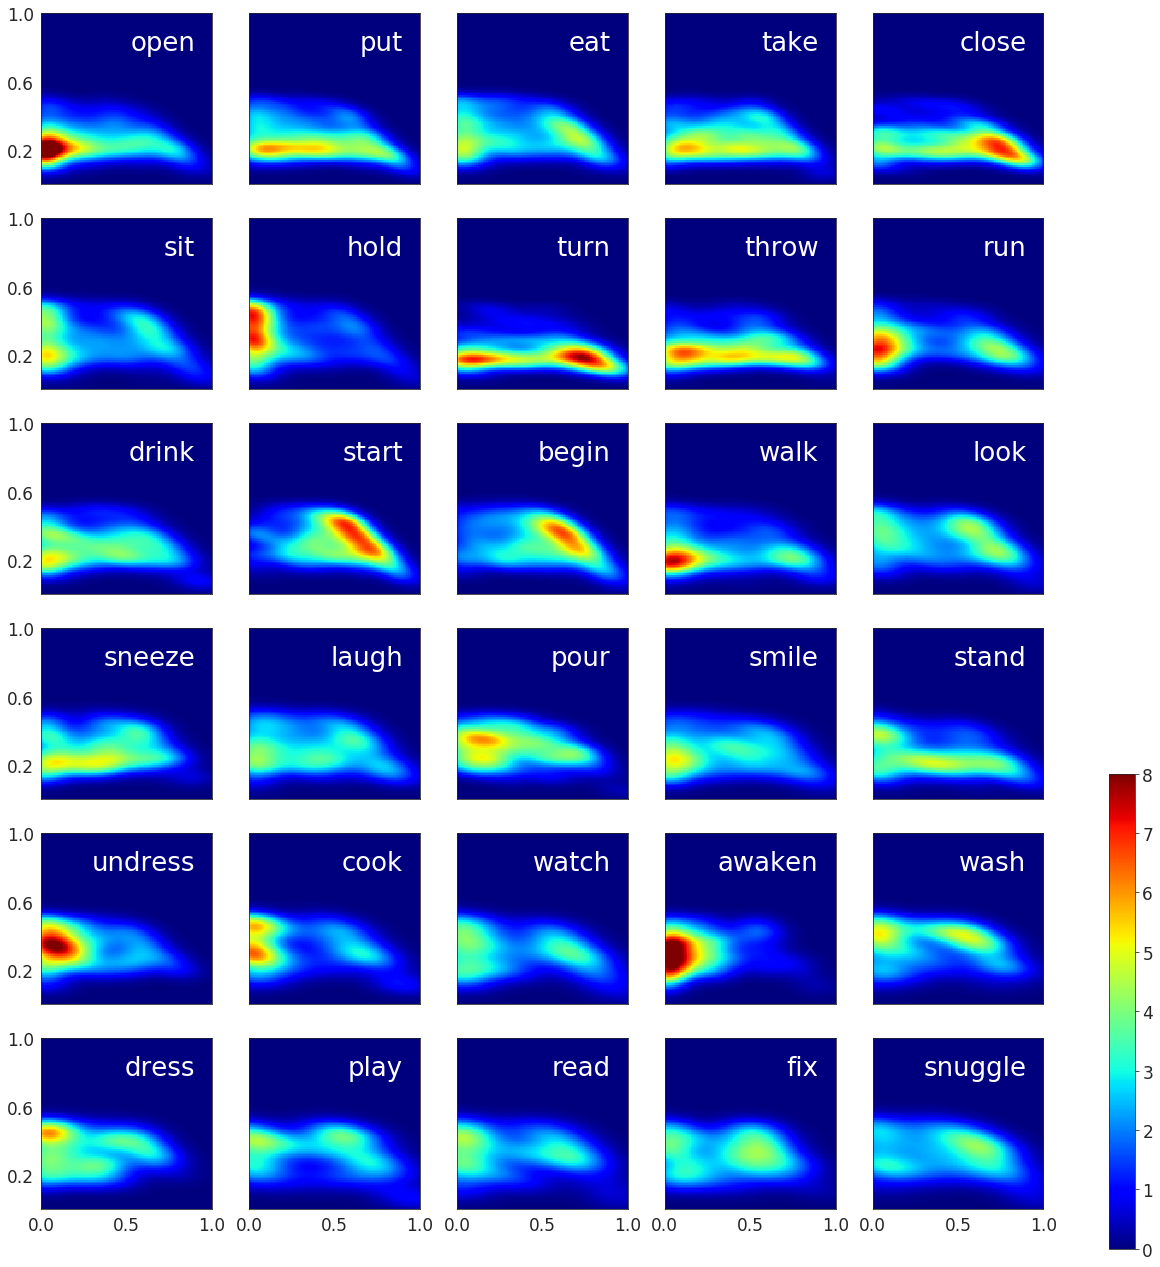

In [79]:
with mpl.rc_context(rc={'font.size': 17}):
    f, axes = plt.subplots(6, 5, figsize=(18, 22))
    axes = axes.ravel()
    for i, (action, kernel) in enumerate(segment_generator.kernels.items()):
        if i==len(axes):
            break
        X, Y = np.mgrid[0:1:100j, 0:1:100j]
        positions = np.vstack([X.ravel(), Y.ravel()])
        Z = np.reshape(kernel(positions).T, X.shape)
        im = axes[i].imshow(np.rot90(Z), cmap=plt.cm.jet, extent=[0, 1, 0, 1], vmin=0, vmax=8)
        axes[i].text(0.9, 0.9, action, ha='right', va='top', color='w', fontsize=26)
        axes[i].grid(False)
        axes[i].set_yticks([0.2, 0.6, 1.0])
        axes[i].set_xticks([0.0, 0.5, 1.0])

        if i%5:
            axes[i].set_yticks([])
        if i<25:
            axes[i].set_xticks([])
    cbar_ax = f.add_axes([0.95, 0.1, 0.02, 0.3])#[left, bottom, width, height]
    f.colorbar(im, cax=cbar_ax)
    plt.savefig(f"reports/figures/dataset visualization/charade-moment-prior.pdf", bbox_inches="tight")

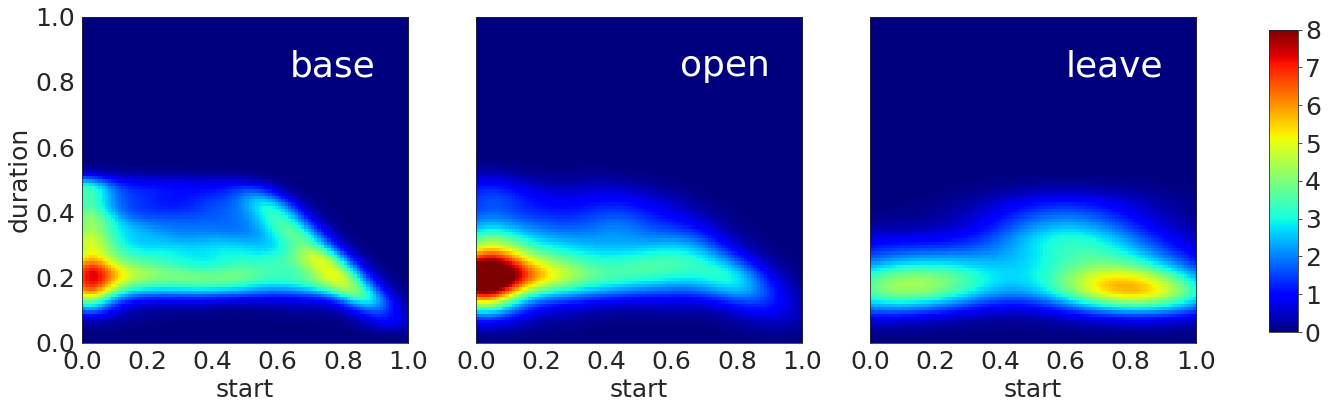

In [80]:
with matplotlib.rc_context(rc={'font.size': 25}):
    f, axes = plt.subplots(1, 3, figsize=(20, 6))
    axes = axes.ravel()
    for i, action in enumerate(['base', 'open', 'leave']):
        kernel = segment_generator.kernels[action]
        if i==len(axes):
            break
        X, Y = np.mgrid[0:1:100j, 0:1:100j]
        positions = np.vstack([X.ravel(), Y.ravel()])
        Z = np.reshape(kernel(positions).T, X.shape)
        im = axes[i].imshow(np.rot90(Z), cmap=plt.cm.jet, extent=[0, 1, 0, 1], vmin=0, vmax=8)
        axes[i].text(0.9, 0.9, action, ha='right', va='top', color='w', fontsize=36)
        axes[i].grid(False)
        axes[i].set_xlabel('start')

        if i>0:
            axes[i].set_yticks([])
        else:
            axes[i].set_ylabel('duration')
            
    cbar_ax = f.add_axes([0.95, 0.15, 0.02, 0.7])#[left, bottom, width, height]
    f.colorbar(im, cax=cbar_ax)
    plt.savefig(f"reports/figures/dataset visualization/charade-moment-prior_(base,open,leave).pdf", bbox_inches="tight")

# Test action prior

In [82]:
test_data = Charade2Instances(pd.read_csv("data/processed/test.csv"))

In [10]:
# action-agnostic baseline
action_agnostic_predictions = predict(blind_segment_generator, test_data, 0.45)
action_agnostic_results = evaluate(test_data, action_agnostic_predictions)
action_agnostic_summary = accumulate_metrics(action_agnostic_results)
f"{action_agnostic_summary['R@1 IoU>0.5'] * 100:.2f}"

R@1 IoU>0.3 0.36
R@1 IoU>0.5 0.23
R@1 IoU>0.7 0.09
R@5 IoU>0.3 0.89
R@5 IoU>0.5 0.67
R@5 IoU>0.7 0.27
R@10 IoU>0.3 1.00
R@10 IoU>0.5 0.91
R@10 IoU>0.7 0.44


In [24]:
# use only first seen verb
predictions = predict(segment_generator, test_data, 0.45)
results = evaluate(test_data, predictions)
summary = accumulate_metrics(results)
f"{summary['R@1 IoU>0.5'] * 100:.2f}"

R@1 IoU>0.3 0.41
R@1 IoU>0.5 0.28
R@1 IoU>0.7 0.11
R@5 IoU>0.3 0.87
R@5 IoU>0.5 0.73
R@5 IoU>0.7 0.36
R@10 IoU>0.3 1.00
R@10 IoU>0.5 0.94
R@10 IoU>0.7 0.48


'28.28'

In [83]:
segment_generator.modes["open"]

array([0.0379562 , 0.20437956])

In [88]:
# Always output mode
def predict_only_modes(
    segment_generator,
    instances
):
    predictions = []
    for instance in instances:
        query, location = instance
        length = location[-1]

        actions, objects = sentence2token(query[1])

        if len(actions):
            actions = [
                action
                for action in actions
                if action in segment_generator.vocab
            ]
            action = actions[0] if len(actions) else "base"
            sample = segment_generator.modes[action]
        else:
            action = "base"
        sample = segment_generator.modes[action]

        bbox = sample.copy()
        bbox[1] = bbox.sum()
        bbox = np.clip(bbox, 0, 1) * length

        predictions.append((query, [bbox.tolist() + [length]], 1))

    return predictions

predictions = predict_only_modes(segment_generator, test_data)
results = evaluate(test_data, predictions, top_k=[1])
summary = accumulate_metrics(results)
f"{summary['R@1 IoU>0.5'] * 100:.2f}"

R@1 IoU>0.3 0.42
R@1 IoU>0.5 0.28
R@1 IoU>0.7 0.11


'28.36'

In [31]:
import pickle as pkl
pkl.dump(results,
    open("reports/figure_src/results/charade/blind(action).pkl", "wb"))

In [9]:
import json

def uniform_sampling(
    instances#: List[Instance],
):
    predictions = []
    for instance in instances:
        query, location = instance
        length = location[-1]
        
        while True:
            location = np.random.uniform(0, 1, (2,))
            if location[0]<location[1]:
                break
        location *= length
        
        predictions.append((query, [location.tolist()+[length]], [1]))

    return predictions

metric = {"R@1 IoU>0.5":[]}
for _ in range(100):
    predictions = uniform_sampling(test_data)
    results = evaluate(test_data, predictions, top_k=[1])
    summary = accumulate_metrics(results)
    metric["R@1 IoU>0.5"].append(summary['R@1 IoU>0.5'])
with open('reports/outputs/performance/charade-sta/random_from_uniform.json', 'w') as f:
    json.dump(metric, f)


R@1 IoU>0.3 0.26
R@1 IoU>0.5 0.11
R@1 IoU>0.7 0.03
R@1 IoU>0.3 0.27
R@1 IoU>0.5 0.11
R@1 IoU>0.7 0.03
R@1 IoU>0.3 0.28
R@1 IoU>0.5 0.11
R@1 IoU>0.7 0.03
R@1 IoU>0.3 0.26
R@1 IoU>0.5 0.11
R@1 IoU>0.7 0.03
R@1 IoU>0.3 0.26
R@1 IoU>0.5 0.11
R@1 IoU>0.7 0.03
R@1 IoU>0.3 0.28
R@1 IoU>0.5 0.11
R@1 IoU>0.7 0.03
R@1 IoU>0.3 0.27
R@1 IoU>0.5 0.11
R@1 IoU>0.7 0.03
R@1 IoU>0.3 0.26
R@1 IoU>0.5 0.11
R@1 IoU>0.7 0.03
R@1 IoU>0.3 0.27
R@1 IoU>0.5 0.10
R@1 IoU>0.7 0.03
R@1 IoU>0.3 0.28
R@1 IoU>0.5 0.11
R@1 IoU>0.7 0.03
R@1 IoU>0.3 0.27
R@1 IoU>0.5 0.11
R@1 IoU>0.7 0.03
R@1 IoU>0.3 0.26
R@1 IoU>0.5 0.10
R@1 IoU>0.7 0.03
R@1 IoU>0.3 0.27
R@1 IoU>0.5 0.11
R@1 IoU>0.7 0.03
R@1 IoU>0.3 0.27
R@1 IoU>0.5 0.10
R@1 IoU>0.7 0.03
R@1 IoU>0.3 0.26
R@1 IoU>0.5 0.11
R@1 IoU>0.7 0.03
R@1 IoU>0.3 0.26
R@1 IoU>0.5 0.11
R@1 IoU>0.7 0.03
R@1 IoU>0.3 0.27
R@1 IoU>0.5 0.11
R@1 IoU>0.7 0.03
R@1 IoU>0.3 0.27
R@1 IoU>0.5 0.11
R@1 IoU>0.7 0.03
R@1 IoU>0.3 0.26
R@1 IoU>0.5 0.11
R@1 IoU>0.7 0.03
R@1 IoU>0.3 0.27
R@1 IoU>0.5 0.

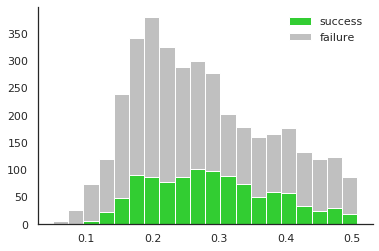

In [29]:
from src.toolbox.visualization import plot_performance_per_duration

plt.rcParams.update({'font.size': 14})
fig = plot_performance_per_duration(results, test_data)
plt.savefig("reports/figures/detailed_analysis/charade/performance_per_duration/blind(action).pdf", bbox_inches="tight")

# Temporal location error

The drop around 0 is due to the removal of success instances.

Text(0.5, 1.0, 'end error')

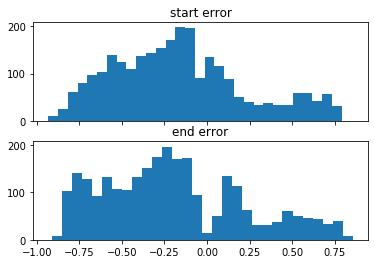

In [16]:
errors = location_error(test_data, results)
start_error = [error[0] for _, error in errors]
end_error = [error[1] for _, error in errors]

f, axes = plt.subplots(2, 1, sharex=True, sharey=True)
axes[0].hist(start_error, bins=30)
axes[0].set_title("start error")
axes[1].hist(end_error, bins=30)
axes[1].set_title("end error")

In [21]:
metrics = []
for nms_thresh in np.linspace(0.4, 0.6, 10):
    predictions = predict(segment_generator, test_data, nms_thresh)
    results = evaluate(test_data, predictions)
    summary = accumulate_metrics(results)
    metrics.append(summary)

/mnt/sda/otani/Experiments/moment_retrieval/src/toolbox/utils.py:48: RuntimeWarning: invalid value encountered in true_divide
  ovr = inter / (lengths[i] + lengths[order[1:]] - inter)
/mnt/sda/otani/Experiments/moment_retrieval/src/toolbox/utils.py:49: RuntimeWarning: invalid value encountered in less_equal
  inds = np.where(ovr <= thresh)[0]


1000
2000
3000
R@1 IoU>0.3 0.42
R@1 IoU>0.5 0.28
R@1 IoU>0.7 0.12
R@5 IoU>0.3 0.89
R@5 IoU>0.5 0.74
R@5 IoU>0.7 0.34
R@10 IoU>0.3 1.00
R@10 IoU>0.5 0.91
R@10 IoU>0.7 0.43
1000
2000
3000
R@1 IoU>0.3 0.42
R@1 IoU>0.5 0.28
R@1 IoU>0.7 0.12
R@5 IoU>0.3 0.89
R@5 IoU>0.5 0.74
R@5 IoU>0.7 0.36
R@10 IoU>0.3 1.00
R@10 IoU>0.5 0.92
R@10 IoU>0.7 0.46
1000
2000
3000
R@1 IoU>0.3 0.42
R@1 IoU>0.5 0.28
R@1 IoU>0.7 0.12
R@5 IoU>0.3 0.87
R@5 IoU>0.5 0.73
R@5 IoU>0.7 0.38
R@10 IoU>0.3 1.00
R@10 IoU>0.5 0.93
R@10 IoU>0.7 0.49
1000
2000
3000
R@1 IoU>0.3 0.42
R@1 IoU>0.5 0.28
R@1 IoU>0.7 0.12
R@5 IoU>0.3 0.86
R@5 IoU>0.5 0.72
R@5 IoU>0.7 0.37
R@10 IoU>0.3 1.00
R@10 IoU>0.5 0.93
R@10 IoU>0.7 0.50
1000
2000
3000
R@1 IoU>0.3 0.41
R@1 IoU>0.5 0.28
R@1 IoU>0.7 0.12
R@5 IoU>0.3 0.85
R@5 IoU>0.5 0.71
R@5 IoU>0.7 0.38
R@10 IoU>0.3 1.00
R@10 IoU>0.5 0.94
R@10 IoU>0.7 0.53
1000
2000
3000
R@1 IoU>0.3 0.42
R@1 IoU>0.5 0.28
R@1 IoU>0.7 0.12
R@5 IoU>0.3 0.83
R@5 IoU>0.5 0.70
R@5 IoU>0.7 0.38
R@10 IoU>0.3 0.99
R@10 IoU>0

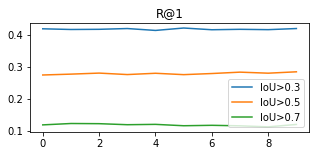

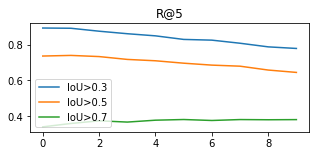

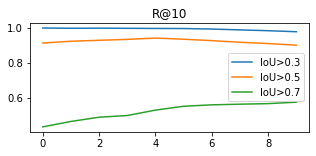

In [22]:
for k in [1,5,10]:
    plt.figure(figsize=(5, 2))
    for thresh in [.3, .5, .7]:
        plt.gca().plot([np.mean(m[f"R@{k} IoU>{thresh}"]) for m in metrics], label=f"IoU>{thresh}")
    plt.title(f"R@{k}")
    plt.legend()
    plt.show()
    plt.close("all")

In [23]:
from src.toolbox.eval import get_first_action, categorize_results, summarize_results_per_class
from src.toolbox.visualization import plot_performance_per_class
import pickle

predictions = predict(segment_generator, test_data, 0.45)
results = evaluate(test_data, predictions)

cat_fn = lambda x: get_first_action(x, segment_generator.vocab)
categorized_results = categorize_results(results, cat_fn)
metrics_per_cls = summarize_results_per_class(categorized_results)

pickle.dump(metrics_per_cls, open("reports/figure_src/metrics_per_cls/charade/action_blind.pkl", "wb"))

class_labels = list(metrics_per_cls.keys())
frequent_class = [label for label in class_labels if len(categorized_results[label]) > 10]
_ = plot_performance_per_class({l: v for l, v in metrics_per_cls.items() if l in frequent_class})

KeyboardInterrupt: 